Oversampling > 2x suggested for reliable results in Fresnel propagation.


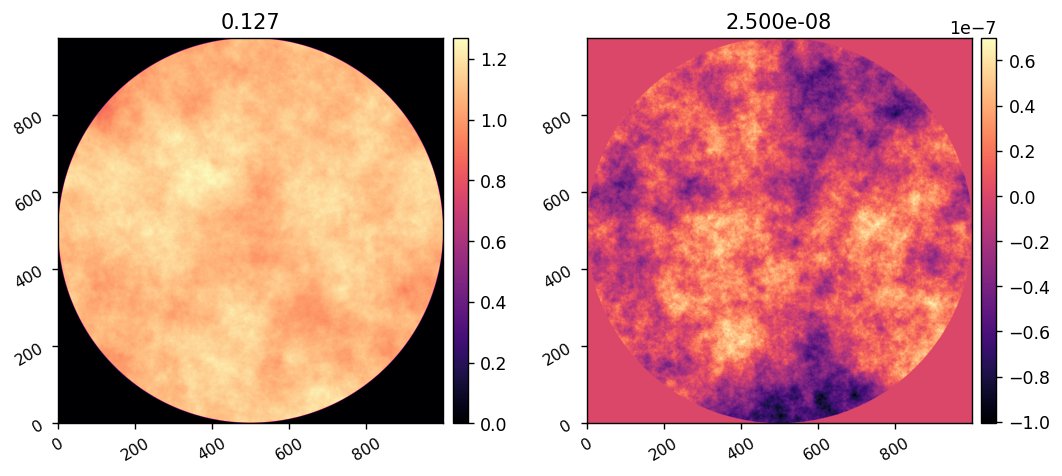

array(2.5e-08)

In [1]:
import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload

from matplotlib.patches import Circle

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.scoob_fraunhofer as scoob
import scoobpsf.dm as dm

import lina

npsf = 200

wavelength = 633*u.nm
pupil_diam = 10*u.mm

reload(utils)
npix = 1000
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=25*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')
lina.utils.rms(wfe_opd[mask])


Oversampling > 2x suggested for reliable results in Fresnel propagation.


(1000, 1000)
(2048, 2048)


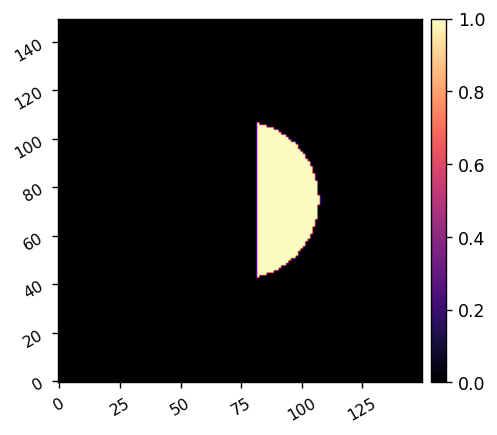

(3000, 3000)
6.479733918357697e-05


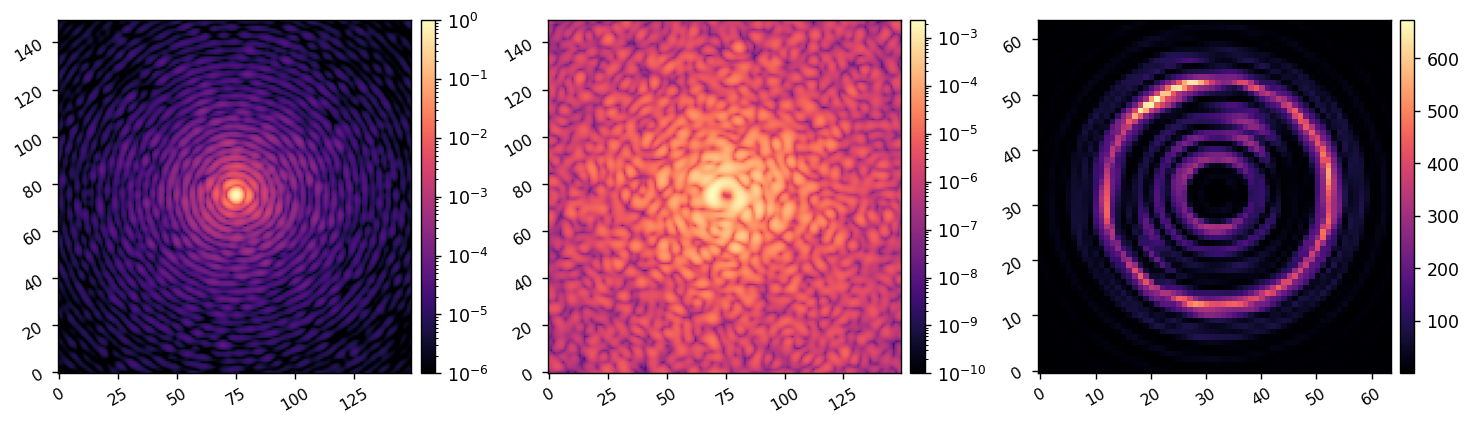

In [2]:
reload(utils)
M = scoob.single()
dark_hole_command = utils.load_fits('data/dark_hole_command.fits')
M.dm_ref = dark_hole_command
M.set_dm(dark_hole_command)
M.WFE = WFE

M.use_llowfsc(False)
M.use_vortex = False
ref_psf = M.snap()
M.Imax_ref = xp.max(ref_psf)

M.use_vortex = True
coro_im = M.snap()

control_mask = lina.utils.create_annular_focal_plane_mask(M.npsf, M.psf_pixelscale_lamD, 2,10,2, plot=True)
mean_contrast = xp.mean(coro_im[control_mask])

M.use_llowfsc()
llowfsc_im = M.snap()

print(mean_contrast)
imshow3(ref_psf/M.Imax_ref, coro_im, llowfsc_im, lognorm1=True, lognorm2=True, vmin1=1e-6, vmin2=1e-10, )


Oversampling > 2x suggested for reliable results in Fresnel propagation.


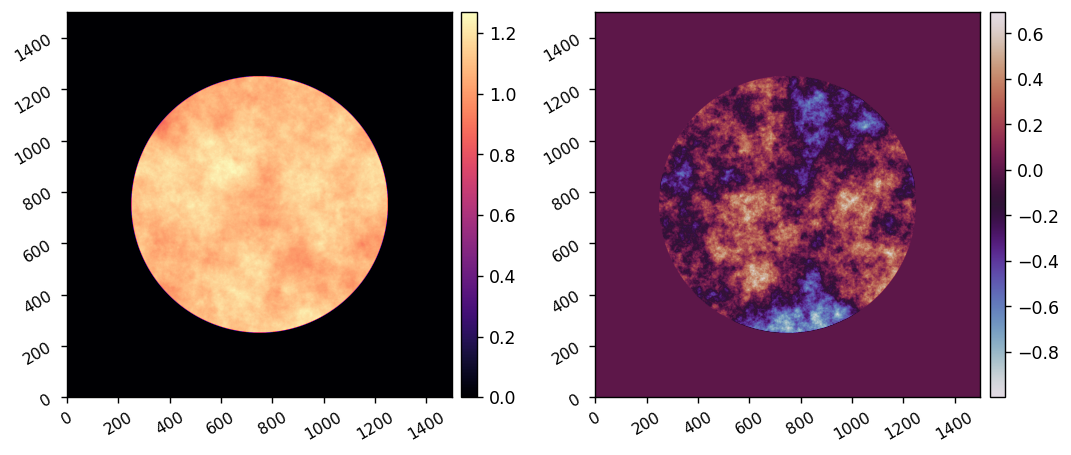

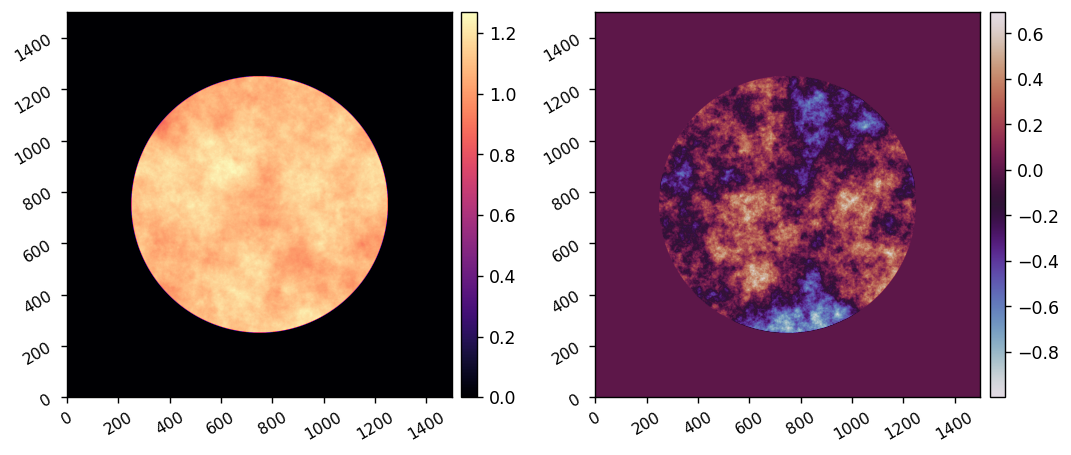

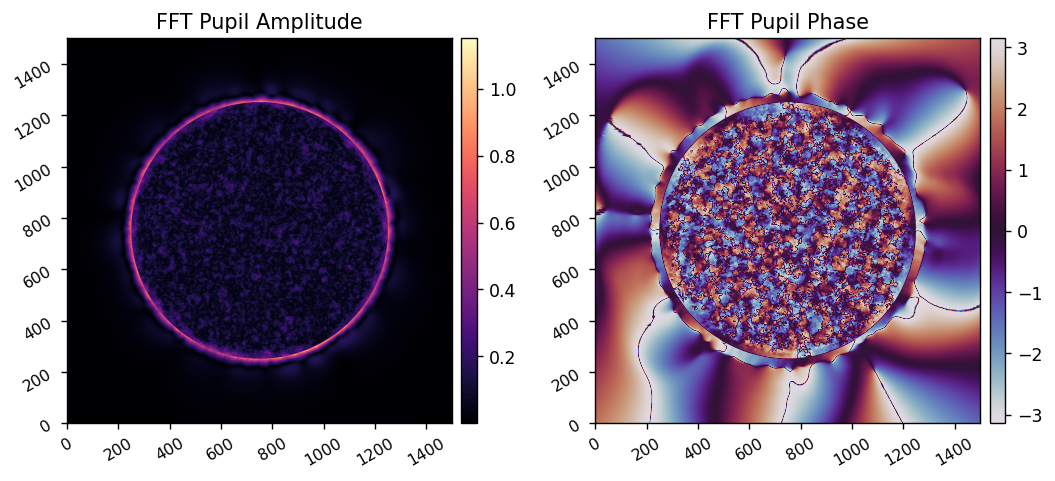

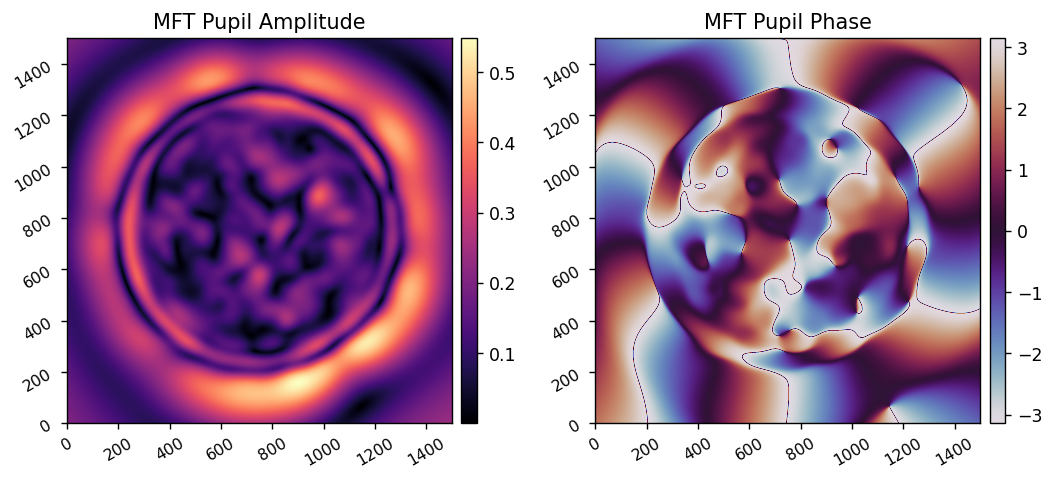

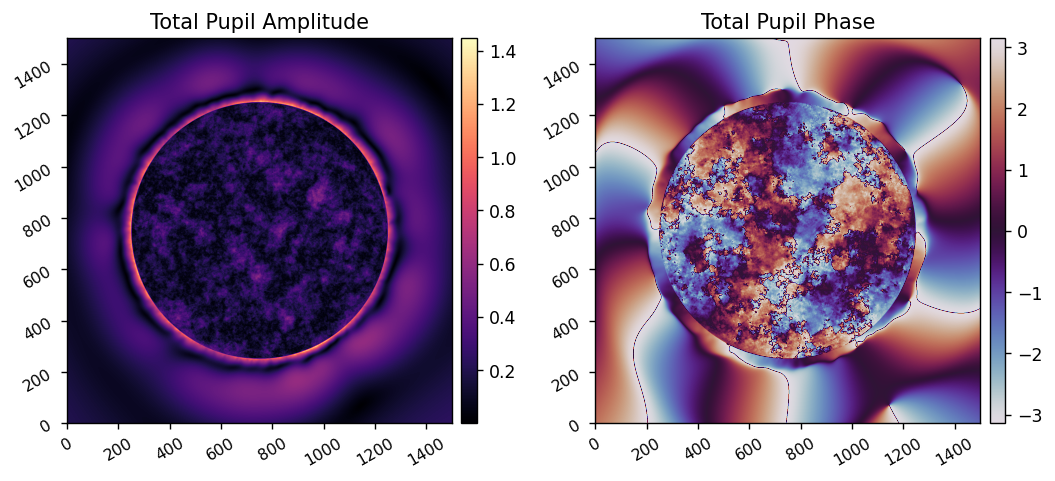

(3000, 3000)


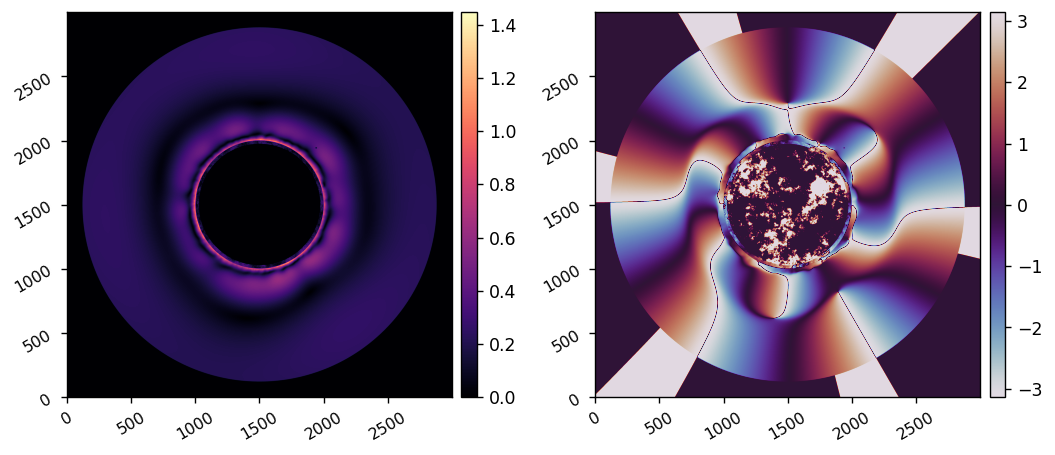

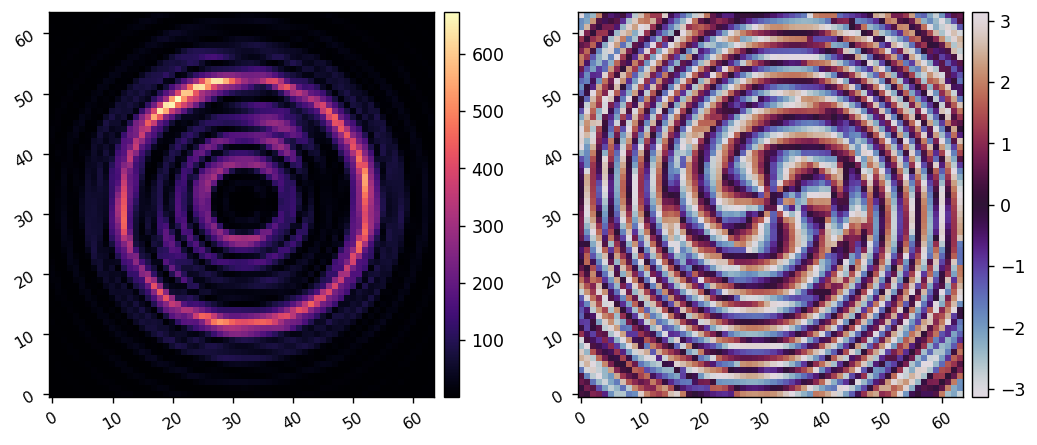

In [3]:
reload(scoob)
M = scoob.single()
M.WFE = WFE
M.use_vortex = True
M.use_llowfsc()
wfs = M.calc_wfs(plot=True)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


(4096, 4096)
(2048, 2048)


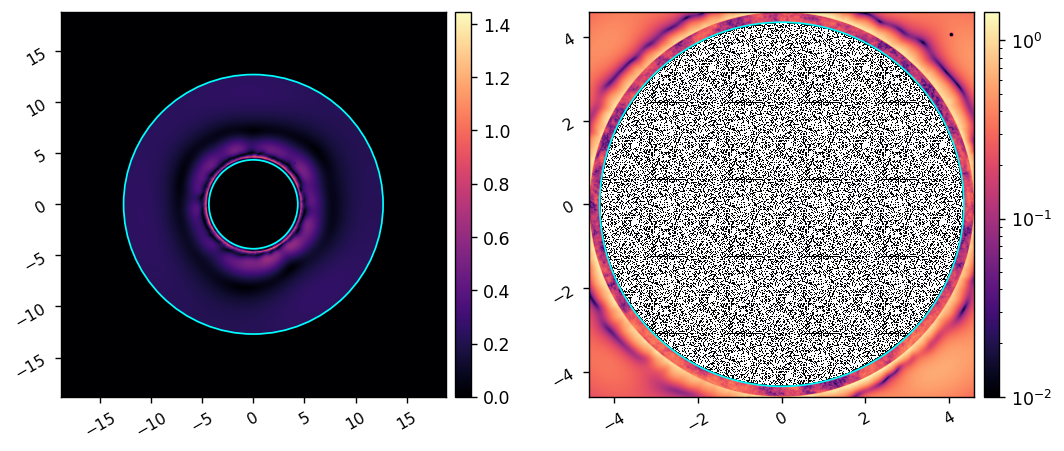

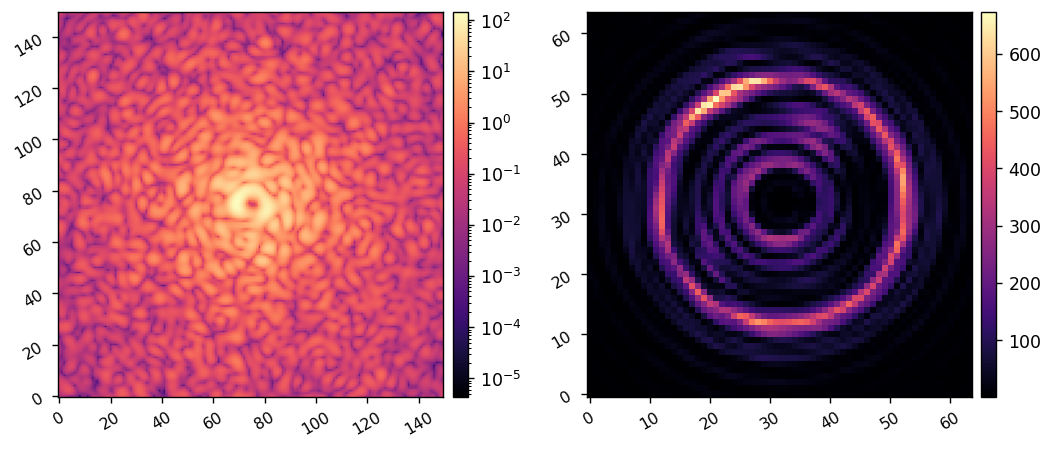

In [10]:
reload(scoob)
M = scoob.single()
M.WFE = WFE
M.use_vortex = True
M.use_llowfsc()
wfs = M.calc_wfs()
llowfsc_im = xp.abs(wfs[-1])**2

M.use_llowfsc(False)
coro_im = M.snap()

# imshow1(im)
imshow2(xp.abs(wfs[-2]), xp.abs(wfs[-2]), npix2=M.npix, lognorm2=True, vmin2=1e-2, 
        pxscl1=M.lyot_pupil_diam/M.npix, pxscl2=M.lyot_pupil_diam/M.npix,
        patches1=[Circle((0,0), 8.7/2, fill=False, color='cyan'),
                  Circle((0,0), 25.4/2, fill=False, color='cyan'),],
        patches2=[Circle((0,0), 8.7/2, fill=False, color='cyan'),],
                  )

imshow2(coro_im, llowfsc_im, lognorm1=True)

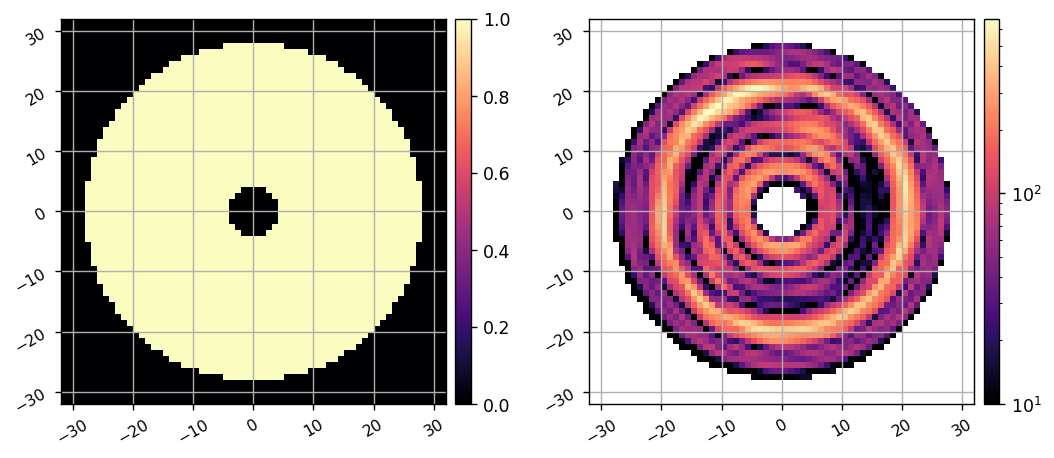

In [20]:
irad = 4
orad = 28
control_mask = lina.utils.create_annular_focal_plane_mask(M.nlocam, 1, irad, orad, edge=None, )

imshow2(control_mask, llowfsc_im * control_mask, grid=True, pxscl=1, lognorm2=True, vmin2=1e1)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


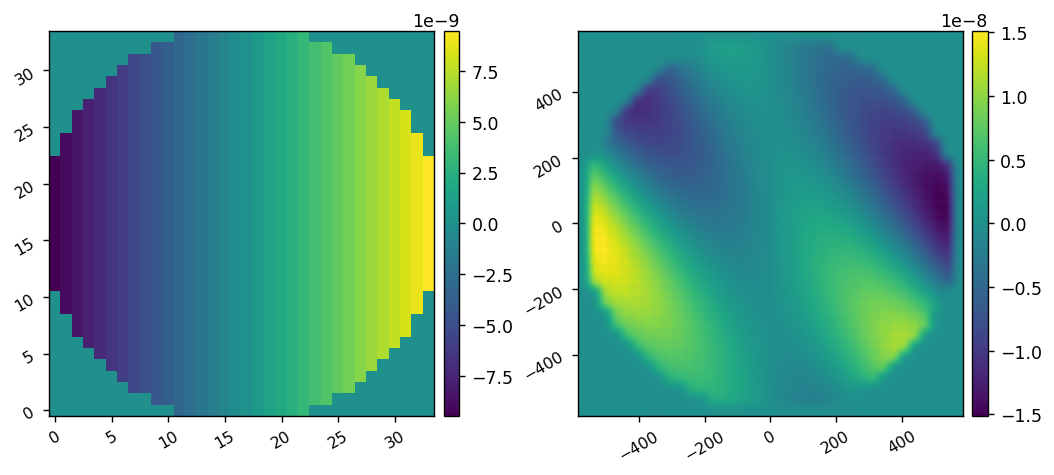

In [15]:
reload(scoob)
reload(scoobpsf.dm)
M = scoob.single()

dm_zernikes = lina.utils.create_zernike_modes(M.dm_mask, nmodes=2, remove_modes=1)
i = 0
M.set_dm(dm_zernikes[i]*5e-9)
dm_surf = M.DM.get_surface()
imshow2(dm_zernikes[i]*5e-9, dm_surf, cmap1='viridis', cmap2='viridis', pxscl2=1)
M.reset_dm()


In [52]:
reload(lina.llowfsc)
M_response = lina.llowfsc.calibrate(M, calib_modes, control_mask, amps=10e-9, plot=True)

<function lina.llowfsc.calibrate(I, calib_modes, control_mask, amps=5e-09, plot=False)>

In [8]:
U, s, Vt = xp.linalg.svd(response_matrix, full_matrices=False)
s.max()/s.min()

array(1.10602814)

In [6]:
# control_matrix = lina.utils.beta_reg(response_matrix, -10)
control_matrix = lina.utils.TikhonovInverse(response_matrix, 1e-15)

# Generate low-order WFE time series. 

In [23]:
initial_jitter = 40*u.mas
dm_pupil_diam = 9.2*u.mm
total_pupil_diam = 2.4*u.m
tt_pv_to_rms = 1/4

mag = total_pupil_diam.to_value(u.m)/dm_pupil_diam.to_value(u.m)

tt_at_dm_pupil = mag * initial_jitter
print(tt_at_dm_pupil)

tt_at_dm_pupil_pv = np.tan(tt_at_dm_pupil).value * dm_pupil_diam
print(tt_at_dm_pupil_pv.to(u.nm))

tt_at_dm_pupil_rms = tt_at_dm_pupil_pv * tt_pv_to_rms
print(tt_at_dm_pupil_rms.to(u.nm))

10434.782608695652 mas
465.421134262201 nm
116.35528356555025 nm


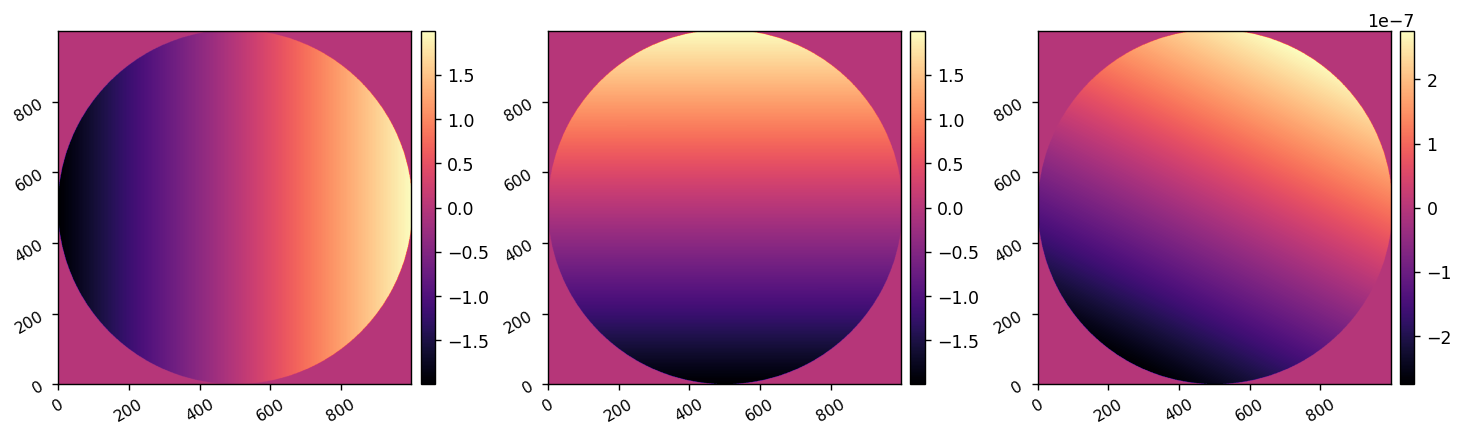

In [53]:
import scoobpsf.psds as psds
reload(psds)

wfe_modes_rms = np.array([tt_at_dm_pupil_rms.to_value(u.m)] * 2)
knee_freqs = np.array([0.3]*2) * u.Hz
fmax = 1000*u.Hz

# wfe_modes_rms = np.array([20e-9]*2 + [5e-9]*3 + [2.5e-9]*6) / 2
# wfe_modes_rms = np.array([10e-9]*2 + [5e-9]*3 + [2.5e-9]*4 + [1e-9]*11)

N_wfe_modes = len(wfe_modes_rms)
wfe_modes = lina.utils.create_zernike_modes(M.APMASK, nmodes=N_wfe_modes, remove_modes=1)

freqs, delF, times = psds.generate_freqs(Nf=2**15+1, f_max=fmax)

wfe_time_series = xp.zeros((N_wfe_modes+1, len(times)))
wfe_time_series[0] = xp.array(times.to_value(u.s))

slope = 4
for i in range(N_wfe_modes):
    f_knee = knee_freqs[i]
    psd = psds.kneePSD(freqs, 1, f_knee, slope)
    coeff = psds.generate_time_series(psd, fmax, rms=1, seed=123+i)
    wfe_time_series[i+1] = wfe_modes_rms[i] * xp.array(coeff)

i = 50000
lo_wfe = xp.sum( wfe_time_series[1:, i, None, None] * wfe_modes, axis=0)
imshow3(wfe_modes[0], wfe_modes[1], lo_wfe)

In [56]:
wfe_time_series.shape

(3, 65536)

1.1635528356555026e-07


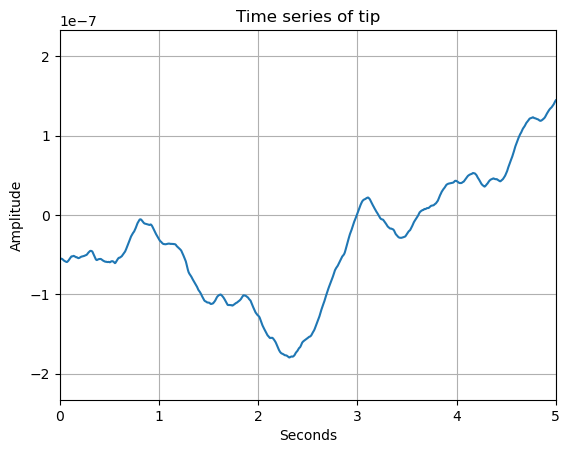

1.1635528356555026e-07


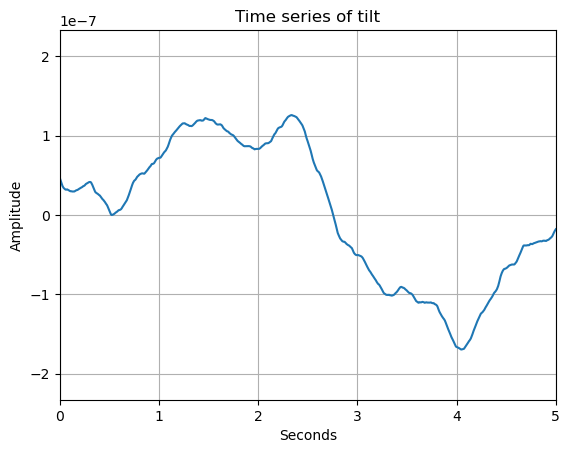

In [55]:
import matplotlib.pyplot as plt

tip = wfe_time_series[1]
print(xp.sqrt(xp.mean(xp.square(tip))))
plt.plot(ensure_np_array(times), ensure_np_array(tip))
plt.title('Time series of tip')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim([0,5])
plt.ylim([-2*tt_at_dm_pupil_rms.to_value(u.m), 2*tt_at_dm_pupil_rms.to_value(u.m)])
plt.xlabel('Seconds')
plt.show()

tilt = wfe_time_series[2]
print(xp.sqrt(xp.mean(xp.square(tilt))))
plt.plot(ensure_np_array(times), ensure_np_array(tilt))
plt.title('Time series of tilt')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim([0,5])
plt.ylim([-2*tt_at_dm_pupil_rms.to_value(u.m), 2*tt_at_dm_pupil_rms.to_value(u.m)])
plt.xlabel('Seconds')
plt.show()

In [104]:
reload(lina)
reload(lina.llowfsc)

Nitr = 100
time_series = xp.zeros((3,Nitr))
for i in range(Nitr):
    time_series[:,i] = pointing_error_time_series[:,i*5]

# M.WFE = WFE * xp.exp(1j*2*np.pi*lo_wfe/M.wavelength_c.to_value(u.m))
M.reset_dm()

coro_ims, llowfsc_ims = lina.llowfsc.run_model(model, 
                                                WFE, 
                                                ref_im=im_ref, 
                                                control_matrix=control_matrix, 
                                                control_modes=dm_zernikes[:2],
                                                time_series=time_series[:,:Nitr], 
                                                zernike_modes=pointing_modes, 
                                                control_mask=control_mask, 
                                                return_all=True, 
                                                # plot=True, 
                                                )

Starting LLOWFSC control-loop simulation: delta T = 2.5000e-03s


Total mean contrast: 5.760e-09
Total mean contrast: 5.760e-09


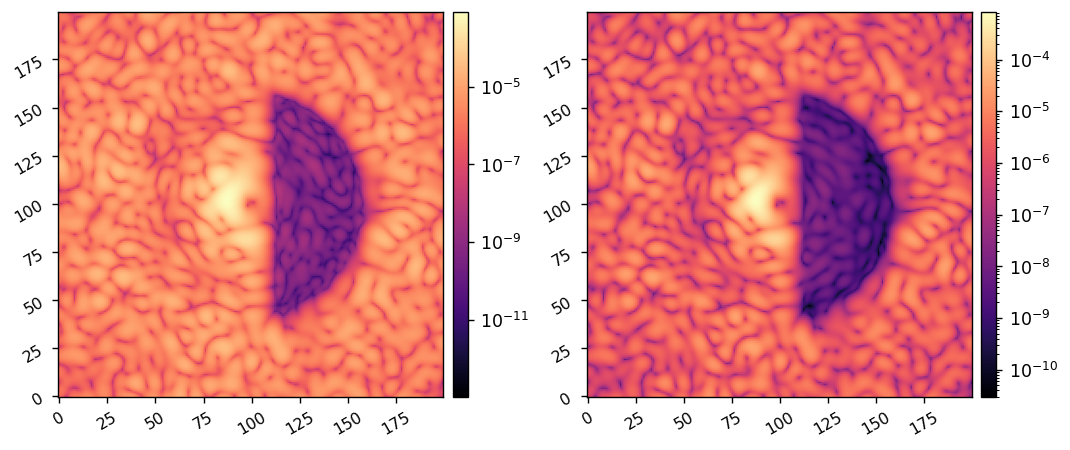

In [105]:
mean_contrasts = xp.mean(coro_ims[:,control_mask], axis=1)
total_mean_contrast = xp.mean(mean_contrasts[5:]) # ignore the first three iterations where we have to converge to a solution first
print(f'Total mean contrast: {total_mean_contrast:.3e}')

mean_coro_im = xp.mean(coro_ims[5:], axis=0)
total_mean_contrast = xp.mean(mean_coro_im[control_mask]) # ignore the first three iterations where we have to converge to a solution first
print(f'Total mean contrast: {total_mean_contrast:.3e}')

diff_ims = llowfsc_ims - im_ref

imshow2(coro_ims[0], mean_coro_im, lognorm=True)